# Fingerprint to Zone Classification
## Introduction
The problem is classification of zone which a user is currently placed in based on some reveiced signals from her mobile phone by the installed sensors (nodes). In this documentation, the designed solution, developed python code, additional notes and analysis and also the results and plots for the problem are given.

To solve the problem at first the data should be read from the input file. Also a solution to store and load data in pickle format is provided.

The next step is preparing the data for the classification. So data should be divided to separated parts (train & test). Data normalization and also feature reduction has been done in this section. Also some primary analysis on data have been done which can provide insight through it and planning a better strategy to tackle the problem. 

Based on the properties of the problem and the dataset, three classifiers (Ransom forest, KNN, and SVM) were selected to be test as classifiers. For each classifier, at first multiple parameters of its model was fitted using cross validation on the train data. Afterwards the trained model of classifier were run on the test data and their prediction accuracy was calculated

At the end, the Results of running each algorithm on the data set(full data set and subsamplee of 100000 random selected rows), discussion and some proposals for further works on the problem is given.
 <!--- This a comment --->
<!--![image_store_good.jpg](attachment:image_store_good.jpg) --->
![image_store_good.jpg](https://github.com/aslanmehrabi/Fingerprint_Classifier/blob/master/image_store_good.jpg)


## Reading the Input
To solve the problem at first the data should be read from the input file. Also a solution to store and load data in pickle format is provided.

> Some notes about the provided dataset (TO DATA OWNERS): Unlike the provided document, the input file was not in ascending order of timestamp, as an example in row number 1993 you can ascending pattern is not respected. Also number of nodes(sensors) was 276 (in the provied document it as mentioned as 261 nodes)

* Class `ProblemData` is developed for reading, storing and loading dataset.
* Function `loadData` will be called to read the data or load from saved pickle file. Also this function can store the input data in a pickle file for faster read data process in next runs. 
* Function `readInput` can be called by "loadData" function to read the data from the input.csv file


In [28]:
import pandas as pd
import json
import csv
from collections import defaultdict
from datetime import datetime
import time
import numpy
import dill as pickle
import random
from sklearn.model_selection import train_test_split

class ProblemData:
    defaultSignalVal = 0  # the min amount of received signal (~ zero value)
    numNodes = 0 # number of sensors(node)
    moment = [] # Time scope of received signal from a suser
    signal = [] # Dictionary of received finger prints
    sigMat = 0  # Matrix of received fignerprints (dimensions: #row_input * # nodes )
    macAdd = [] # array of Mac add of mobile phones
    zone = [] # array of zones of users in each line on input
    numRows = 0 # total number of rows of input which should be considered

    def __init__(self, defaultSignalValue = -100, numNodes = 277):
        self.defaultSignalVal = defaultSignalValue
        self.numNodes = numNodes

    def loadData(self,  useStoredData=False, inputFileName='', storeReadData = 'False',storeDataName='default_store_name', rowReadUntil = -1):
        if useStoredData:
            storedData = open(storeDataName, 'rb')
            self = pickle.load(storedData)  
            storedData.close()
            return self

        else:
            if (inputFileName == ''):
                print('======> inputFileName field should be passed')
                return self

            self.readInput(fileName=inputFileName,rowReadUntil=rowReadUntil)  #  To reaad limited number of row
            if(storeReadData):
                storedData = open(storeDataName, 'wb')
                pickle.dump(self, storedData)
                storedData.close()
            return self
        
    # read the data from the input file
    def readInput(self , fileName, rowReadUntil = -1):
        dataAddrMain = fileName
        with open(dataAddrMain) as csvfile:
            readCSV = csv.reader(csvfile, delimiter=',')


            if rowReadUntil != -1:
                self.numRows = rowReadUntil
            else:
                self.numRows = sum(1 for row in readCSV) - 1
                csvfile.seek(0)  # moving back to the first line of the input

            # next(reader) # skip header
            for idx, row in enumerate(readCSV):
                if idx == 0:
                    header = row
                else:
                    #if(idx % 10000 == 0):
                       #print('row reading: ',idx)
                    tmpTime = datetime.strptime(row[0], "%Y-%m-%d %H:%M:%S")
                    self.moment.append(time.mktime(tmpTime.timetuple()))
                    self.signal.append(json.loads(row[1].replace("'", "\"")))  # converting to dict type
                    self.macAdd.append(int(row[2]))
                    self.zone.append(int(row[3].split(' ')[1]))
                    if (idx == self.numRows):  # to read limited number of rows defined by rowReadUntil
                        break

            self.signal = [dict([int(a), int(x)] for a, x in b.items()) for b in self.signal]  # converting signals to int values 
            self.signal = [defaultdict(lambda: self.defaultSignalVal, sig) for sig in self.signal]  # add default signal value for probes which did not get any signal
            self.sigMat = numpy.full((self.numRows, self.numNodes), self.defaultSignalVal)  # signal matrix: each node is a column
            for i in range(self.numRows):
                self.sigMat[i][list(self.signal[i].keys())] = list(self.signal[i].values())  

            self.zone = numpy.full(self.numRows, self.zone)  # convering zone to numpy Array
            self.moment = numpy.full(self.numRows, self.moment) 
            self.macAdd = numpy.full(self.numRows, self.macAdd)
            return self.checkRecievedData()

    def checkRecievedData(self):  # can be added to check the validity of read input
        return True

## Preparing data
The next step is preparing the data for the classification. Data should be divided to separated parts (train & test). 
* An object of `DataPartition` is prepared data for classification which contains feature vector and labels of train and test data.
* Function `makeTrainTest` can split data to train and test partitions of specific size defined by user, also load and store feature vectors(if asked by user). Also this function can make a normal distribution of data (if asked by user)

In [29]:
import dill as pickle
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,normalize
import copy

class DataPartition:

    fVecTrain = [] # feature vector for train set
    fVecTest = [] # feature vector for test set
    labelTrain = [] # labels of train set
    labelTest = [] # labels of test set
    isNormalized = False  # shows whether the data has been normalized


# split data to train and test partitions of specific size defined by user + load stores feature vectors(if asked by user) + do data normalization (if asked by user)
    def makeTrainTest (self, prblmData, readSampleSize = -1, testPartitionSize = 0.3,randomState = 0 ,doNormalize = False, useSubSample = False, storeSubSample = False, subSamplePcklName = ''):
        if useSubSample:
            storedData = open(subSamplePcklName, 'rb')  
            self = pickle.load(storedData)
            storedData.close()
            return self

        else :
            if(readSampleSize == -1):
                readSampleSize = prblmData.numRows
            sampleSize = min(readSampleSize, prblmData.numRows)  # select sampleSize of random indices of rows


            randInd = random.sample(range(prblmData.numRows), sampleSize)
            self.isNormalized = doNormalize
            if doNormalize :
                normalSigMat = StandardScaler().fit_transform(prblmData.sigMat)  
                self.fVecTrain, self.fVecTest, self.labelTrain, self.labelTest = train_test_split(normalSigMat[randInd],prblmData.zone[randInd],test_size=testPartitionSize,random_state=randomState)

            else:
                self.fVecTrain, self.fVecTest, self.labelTrain, self.labelTest = train_test_split(prblmData.sigMat[randInd],prblmData.zone[randInd],test_size=testPartitionSize,random_state=randomState)

            if storeSubSample:  # stores train and test data as pickle file
                storedData = open(subSamplePcklName, 'wb')
                pickle.dump(self, storedData)
                storedData.close()

        return self
    

## An engine to run classifier
Before defining classifiers, a function which is able to train a classifier on a given train data and apply it on test data is needed. Also this function should be able to provide the accuracy of classifier and other details as well as plotting corresponding plots
* Funcion `doClassification` of class `RunClassifier` is defined for this purpose.

In [30]:
import pickle  # to load and store data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import dill as pickle

class RunClassifier:

    # receives a classifier(clf) and set of test and train data and corresponding labels. This function ...
    # ... apply the classifier on the data and provides accuracy and related plots of classification. Also ...
    # ... it is able to store the trained classifier(with train data) as a pickle file
    def doClassification(self, clf, fVecTrain, fVecTest, labelTrain, labelTest, showPlot=False,savePickleModel=False, clfName='clf', dataType = 'data'):
        print('clf: %s'%(clf) )
        print("Model : %s - Data: %s - SampleSize: %d"%(clfName, dataType,len(labelTrain) + len(labelTest)))
        print('learning started')
        clf.fit(fVecTrain, labelTrain)
        print('model fitted')
        prediction = clf.predict(fVecTest)

        print('# True pred: ', sum(prediction == labelTest))
        print('# False pred: ', sum(prediction != labelTest))

        accuracy = accuracy_score(labelTest, prediction)
        # print("Accuracy :{}", .format(accuracy_score(labelTest, prediction)))
        conf_matrix = confusion_matrix(y_true=labelTest, y_pred=prediction)
        print("Accuracy : ", accuracy)
        print('best parameter: ', clf.best_params_)  # shows the best parametrs of the classifier which was selected by cross validation

        if showPlot:
            plt.matshow(conf_matrix)
            plt.title("Model : %s - Data: %s - SampleSize: %d"%(clfName, dataType,len(labelTrain) + len(labelTest)))
            # plt.show()
            plt.savefig(clfName + ' ' + dataType +' '+str(len(labelTrain) + len(labelTest)) + ' ' + '.png')

        if savePickleModel:  # store pickle file of trained classifier
            storedData = open((str(clf).partition('(')[0]) + '_' + str(len(labelTrain) + len(labelTest)) + '.pckl','wb')
            pickle.dump(clf, storedData)
            storedData.close()

        return prediction, accuracy, conf_matrix, clf.best_params_


## Initializing parameters of the program
Before running the main part of program, some parameters should be initialize by the user of the software. These parameters and their description are shown below:

In [35]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
#from ProblemData import ProblemData
#from Data_Partition import DataPartition
#from RunClassifier import RunClassifier
from sklearn import svm, grid_search, datasets

inputFileName = 'fingerprints_gt_ver3.csv'

readDataUntilRow = -1  # define number of rows which should be read form input file. -1: read the whole data
sampleSize = 10000  # define sizse of sample which provides test and train data. -1: readDataUntil will be considered
testPartitionSize = 0.2   # size of the partition of the input size which will be separated as test data

defaultSignalValue = -100  # default(min) value which a sensor(node) can receive
numNodes = 277  # total number of nodes

useStoredData = False  # use stores input data as packle file
storeReadData = False  # store read data from input to a packle file
storeSubSample = False  # store selected subsample as a packle file
useSubSample = False   # load stored subsample from packle file
savePickleModel = False  # store trained classifier after making the learners [new test data can be run on them immediately]

subSamplePcklName = '1000SubSampleVector.pckl'  # name of file to store selected subsample as packle file
storeSubSampleName = 'storeSubSample.pckl'  # name of file to load selected subsample as packle file
storeDataName = 'store.pckl' # name of file to store input file as a packle


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Make Train Test sets as original form, normalized and feature reduced
Feature vector for the input data consists of values of each detected signal by nodes for a single row (fingerprint). In the discussion section the reasons to select this feature vector is provided; also some proposal to improve the feature vectors are mentioned there. Labels for each row of data is the corresponding zone.
Here the loaded data is prepared in three formats:
* Original Data: Data provided in the input
* Normalized Data: Normalization has been done on the original data
* Feature reduced: Feature reduction of normalized data using PCA

These formats of data will be used as datasets for classifiers


In [ ]:
# loading the data as prblmData
prblmData = ProblemData(defaultSignalValue=defaultSignalValue, numNodes=numNodes)
prblmData = prblmData.loadData(useStoredData=useStoredData, inputFileName=inputFileName, storeReadData = storeReadData, storeDataName=storeDataName,
                               rowReadUntil=readDataUntilRow)

# partitioning data and providing test and train sets and corresponding labels as dataPar 
dataPar = DataPartition()
dataPar = dataPar.makeTrainTest(prblmData=prblmData, readSampleSize=sampleSize, testPartitionSize=testPartitionSize,
                                randomState=0, doNormalize=False, useSubSample=useSubSample, storeSubSample=True,
                                subSamplePcklName=subSamplePcklName)

# providing normalized data of dataPar as dataParNormal
dataParNormal = DataPartition()
dataParNormal = dataParNormal.makeTrainTest(prblmData=prblmData, readSampleSize=sampleSize,
                                            testPartitionSize=testPartitionSize, randomState=0, doNormalize=True,
                                            useSubSample=useSubSample, storeSubSample=True,
                                            subSamplePcklName=subSamplePcklName)


# Feature reduction of normalized data by PCA(with pcaNcomponents dimensions) as dataParPca 
pcaNcomponent = 10
pcaObj = PCA(n_components = pcaNcomponent )
fit = pcaObj.fit(dataParNormal.fVecTrain)
dataParPca= DataPartition()
dataParPca.fVecTrain = pcaObj.fit_transform(dataParNormal.fVecTrain)
dataParPca.fVecTest = pcaObj.fit_transform(dataParNormal.fVecTest)
dataParPca.labelTrain = dataParNormal.labelTrain
dataParPca.labelTest = dataParNormal.labelTest
dataParPca.isNormalized = True

    

## Plotting input data by PCA
First and second principle components of applied PCA on data is used to plot all the points and give an insight toward dataset

>This figure can be plotted for your selected data if you run the program from the beginning of this file. Also 2D-PCA of sample of 100000 random selected rows of input is shown below:
>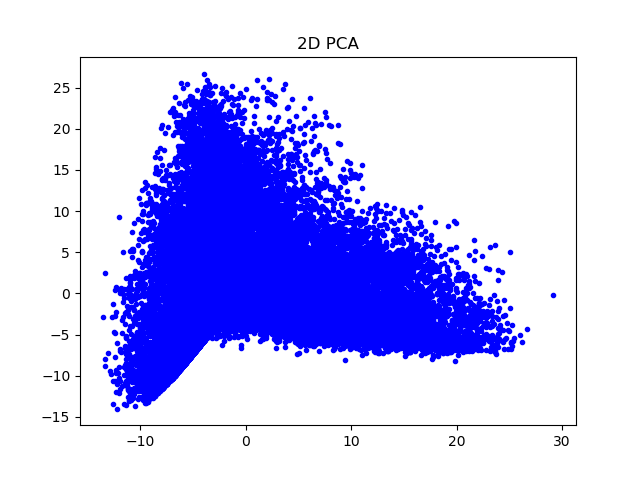


In [ ]:
# plotting data by first and second principle components of applied PCA on data
    plt.plot(dataParPca.fVecTrain[:,0], dataParPca.fVecTrain[:,1], 'b.')
    plt.title('2D PCA')
    plt.show()

## Classifiers: 
Now it is time to determine our classifiers and their hyper parameters. Considering the under considered problem and corresponding datasets, three classifier has been selected to be implemented on the data:
* Random forest
* K nearest Neighbors (KNN)
* Support vector Machines (SVM)

Details of how each of these classifiers has been used and tuned for the problem with the corresponding code are given below
* parameter cv shows number of partitions for cross validation of hyper parameter tuning
* n_jobs = -1 run the data on multiple cores

## Random forest

Random forest with three hyper parameters parameters has been used:
* n_estimators: number of trees to make the forest
* criteria: measuring quality of a split. “gini” for the Gini impurity and “entropy” for the information gain
* max_features: number of features to consider when looking for the best split

In [ ]:
paramGrid_rf = {'n_estimators': [5, 10, 17, 30], 'criterion': ['gini', 'entropy'],'max_features': ['auto', 0.01, 0.1, 0.9], 'n_jobs': [-1]}
#paramGrid_rf = {'n_estimators': [30] ,'criterion': ['gini'] ,'n_jobs': [-1]} # n_jobs => runs in parallel
clf_rf = GridSearchCV(RandomForestClassifier(), paramGrid_rf, cv=3)  

## KNN:
KNN with the following parameters has been used:
* n_neighbors: number of neighbors to consider
* weights: how to weight labels of neighbors. uniform or distance(consider reverse of the neighbors distance)
* metric: how to measure the distance: 'minkowski', 'euclidean' or 'manhattan'

In [ ]:
paramGrid_knn = {'n_neighbors': [3, 5, 9, 15], 'weights': ['uniform', 'distance'],'metric': ['minkowski', 'euclidean', 'manhattan']}
#paramGrid_knn = {'n_neighbors': [5, 9], 'weights': ['distance'],'metric': ['manhattan']}
clf_knn = GridSearchCV(KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1), paramGrid_knn, cv=3) #, verbose=10  # ,scoring='%s_macro' % score

## SVM:
SVM with the following parameters has been used:
* C : Penalty parameter for miss classification
* kernel: used kernel 'linear', 'poly', 'rbf' // rbf is more time consuming but seems to be more concordat to problem
* gamma: kernel coefficient. How far the influence of a single training data reaches [low: far / high: close]


In [ ]:
param_grid_svm = {'C': [0.01, 0.1, 1, 10], 'kernel': ['linear', 'poly', 'rbf'], 'gamma': [0.001, 0.01, 0.1, 1]} # rbf is time consuming comparing to others
#param_grid_svm = {'C': [0.1], 'kernel': ['rbf'], 'gamma': [0.01]}
clf_svm = GridSearchCV(svm.SVC(), param_grid_svm, cv=3) # , verbose=10: write the result of each epoc of cv

## Running the Classifiers - Fasten your seatbelts!
By now, Data has been read, converted to suitable formats (original, normalized, feature reduced) of test and train. 
Also three classifiers (random forest, KNN, SVM) has been defined with hyper parameters.
It is time to run the classifiers on the data. First by cross validation, hyper parameters should be tuned. 
After that the trained classifiers with selected hyper parameters should be implemented on the test data to determine the classification accuracy and the best classifier.

For each classifier and each type of data function `RunClassifier.doClassification` will be called

In [ ]:
# determine the classifiers and the sets of data to train the each classifiers on each set of data type
clfNames = ['random_forest', 'knn', 'svm']
dataTypes = ['original ','normalized','nomalized_PCA']

for idx, clf in enumerate([clf_rf , clf_knn, clf_svm]):
    for idx2,datap in enumerate([dataPar, dataParNormal, dataParPca]):
        runCl = RunClassifier()
        prediction, accuracy, conf_matrix, clf.best_params = runCl.doClassification(clf, datap.fVecTrain,datap.fVecTest, datap.labelTrain,datap.labelTest,showPlot=True,savePickleModel=savePickleModel,clfName = clfNames[idx],dataType = dataTypes[idx2])
        print('\n+++++++++++++++++++\n')


## Result
The mentioned Algorithms (random forest, KNN, SVM) and prepared data types(Original, normalized, feature reduced by PCA in 10 dimension) were run on the input data. Algorithms were run on Subsample of data (100000 rows ) to get the result and using best achieved hyper parameters of this run, algorithms were run on all the dataset (343449 rows). I should note that if a better hardware was available, hyper parameter tuning could be done more accurately for the whole dataset and it would result in improvement of classification accuracy. 

**As shown below, the best classifier is Random forest with 0.78 accuracy of prediction.** 

### Run on whole data (343449 rows)
| Classifier    | cv-fold       | Data type | Accuracy | Hyper Parameters
| -----------   |       ------- |  -----    | ------- |   -----------
| Random forest | 3             | original  | __**0.78**__| n_estimators: 10,**30** - criterion: **gini**
| Random forest | 3             |   normal  | 0.78     | n_estimators: 10,**30** - criterion: **gini**
| KNN           |      3        |   original|  0.71    |  n_neighbors: 5,**9** - weights: **distance** - metric: **manhattan**
| KNN           |      3        |   normal  |    0.71  |n_neighbors: 5, **9** - weights: **distance** - metric: **manhattan**
| KNN           |      3        |   PCA(10D)|    0.71  |n_neighbors: 5, **9** - weights: **distance** - metric: **manhattan**


### Run on subsample (100000 rows)
| Classifier    | cv-fold       | Data type | Accuracy | Hyper Parameters
| -----------  |        ------- |  -----    | ------- |   -----------
| Random forest | 5             | original  |  0.74    | n_estimators:5,10,17,**30** - criterion: **gini**, entropy  - max_features: auto, 0.01, **0.1**, 0.9
| Random forest | 5             |   normal  | 0.75     | n_estimators:5,10,17,**30** - criterion: **gini**, entropy  - max_features: auto, 0.01, **0.1**, 0.9
| Random forest |      3        |   PCA(10D)|  0.74    |  n_estimators:5,10,17,**30** - criterion: **gini**, entropy
| KNN           |      5        |   original|  0.66    |  n_neighbors: 3, **9** - weights: **distance** - metric: **manhattan**
| KNN           |      5        |   normal  |    0.66  |n_neighbors: 3, **9** - weights: **distance** - metric: **manhattan**
| KNN           |      5        |   PCA(10D)|    0.34  |n_neighbors: 3, **9** - weights: **distance** - metric: **manhattan**
| SVM           |      3        |  original |   0.01   | C: **0.1**, gamma: **0.01**, kernel: **rbf**
| SVM           |      3        |  PCA(10D) |0.23      | C: **0.1**, gamma: **0.01**, kernel: **rbf**


Note that subsampling of size 100000 where generated by random indexing of all rows
selected hyper parameters using k-fold cross validation (k = cv-fold) is shown bold in the Hyper parameters column.

> Confusion matrix for the best answer (random forest on whole data) is shown below:!
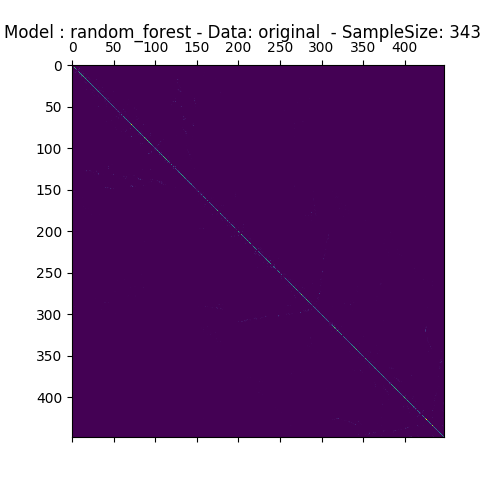

Note that as the problem is multi label classifier, overall precision, recall and F1 score cannot be calculated and each of these parameters can be calculated for each label (one versus all).
